This notebook is based on the [send-receive-pulse demo](../qick_demos/00_Send_receive_pulse.ipynb).

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

# Custom bistream
FERMILAB_BIT = 'qick_216.bit'

# Normalize path
FERMILAB_BIT = os.path.normpath(os.getcwd() + '/' + FERMILAB_BIT)

print('Custom bitsream:', FERMILAB_BIT)

Custom bitsream: /home/xilinx/jupyter_notebooks/qick/qick_ml/qick_216.bit


In [3]:
# Load bitstream with custom overlay
soc = QickSoc(bitfile=FERMILAB_BIT)
# Since we're running locally on the QICK, we don't need a separate QickConfig object.
# If running remotely, you could generate a QickConfig from the QickSoc:
#     soccfg = QickConfig(soc.get_cfg())
# or save the config to file, and load it later:
#     with open("qick_config.json", "w") as f:
#         f.write(soc.dump_cfg())
#     soccfg = QickConfig("qick_config.json")
soccfg = soc
print(soccfg)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.175
	Firmware timestamp: Tue Aug 29 10:29:03 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	1:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	2:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	3:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	4:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 6, envelope memory 65536 samples
		DAC ti

### Hardware Configuration

generator channel 6   : DAC 229 CH3  <-> Readout channel 0 : ADC 224 CH0

In [4]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        # fire the pulse
        # trigger all declared ADCs
        # pulse PMOD0_0 for a scope trigger
        # pause the tProc until readout is done
        # increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))
        
        # equivalent to the following:
#         self.trigger(adcs=self.ro_chs,
#                      pins=[0], 
#                      adc_trig_offset=self.cfg["adc_trig_offset"])
#         self.pulse(ch=self.cfg["res_ch"])
#         self.wait_all()
#         self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

### Load an excited state

In [5]:
config={"res_ch":6, # --Fixed
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":45, # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":100, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":200, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":6000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":1
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)

  0%|          | 0/1 [00:00<?, ?it/s]

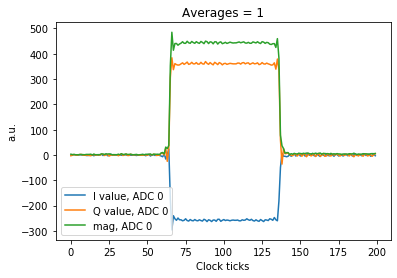

In [6]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
plt.savefig("images/Send_recieve_pulse_const.pdf", dpi=350)

In [7]:
from ctypes import *
def to_float(i):
    cp = pointer(c_int(i))
    fp = cast(cp, POINTER(c_float))
    return fp.contents.value

from pynq import MMIO

base_address = 0x00_A013_0000
bram_size = 64

mmio = MMIO(base_address, bram_size)
ground_state_logit = mmio.read(0)
excited_state_logit = mmio.read(4)
if (ground_state_logit > excited_state_logit):
    print("Prediction: ground state")
else:
    print("Prediction: excited state")
print('Logit values as int: [', ground_state_logit, ',', excited_state_logit, ']')
print('Logit values as hex: [', hex(ground_state_logit), ',', hex(excited_state_logit), ']')
print('Logit values as flt: [', to_float(ground_state_logit), ',', to_float(excited_state_logit), ']')


Prediction: ground state
Logit values as int: [ 1076887552 , 0 ]
Logit values as hex: [ 0x40300000 , 0x0 ]
Logit values as flt: [ 2.75 , 0.0 ]


### Rep-to-rep consistency
In this notebook we mostly use decimated readout (we acquire a full waveform, not just a single accumulated value). To avoid exhausting the waveform buffer, we usually run with reps=1 (the tProcessor program only fires+reads one pulse, and we run the program `soft_avgs` times).

However, it's important to check that if you run a tProcessor loop with reps>1, the pulse looks the same in each iteration of the loop. So let's do a decimated readout with multiple reps; the 1024-sample buffer will allow for 10 reps of 100 samples each.

Try changing the relax_delay to 0. You will see that the first rep appears in the same place, but the others are delayed by a bit because the tProcessor didn't have enough time between waiting for the measurement in one rep and firing the pulse in the next rep.

### Multiple triggers
You can send multiple triggers inside a loop. The `acquire()` and `acquire_decimated()` methods take a `readouts_per_experiment` parameter which must equal the number of triggers.

Let's check the rep-to-rep consistency as well as the consistency between the first and second trigger.

### Multiple pulses

Here's an example of playing multiple pulses from the same generator, with a 90-degree shift in the carrier phase between the two pulses.

### Send/receive a pulse with <code> pulse_style </code> = <code> flat_top </code>

### Send/receive a pulse with <code> pulse_style </code> = <code> arb </code>

In [ ]:
config={"res_ch":6, # --Fixed
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "arb", # --Fixed
        
        "sigma": 30, # [Clock ticks]
        # Try varying sigma from 10-50 clock ticks
        
        "readout_length":300, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":5000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)


In [ ]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
plt.savefig("images/Send_recieve_pulse_arb.pdf", dpi=350)

### Compare the two main ways of acquiring data: <code>prog.acquire_decimated</code> and <code>prog.acquire</code>

In the previous two demonstrations we used <code>prog.acquire_decimated</code> which uses the QICK decimated buffer (acquiring a whole time trace of data for every measurement shot. The QICK accumulated buffer is used in <code>prog.acquire</code>, which acquires a single I/Q data point per measurement shot- the average of the I/Q values in the decimated buffer. In qubit experiments we will be mainly using <code>prog.acquire</code> since for every shot we only need one I/Q value to assess the state of the qubit. So let's verify that <code>prog.acquire_decimated</code> and <code>prog.acquire</code> produce similar results (to within +/- 1 DAC units).

In [ ]:
# First, lets collect the results with the decimated buffer as we did before.
config={"res_ch":6, # --Fixed
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "const", # --Fixed
        "length":20, # [Clock ticks]        
        "readout_length":200, # [Clock ticks]
        "pulse_gain":10000, # [DAC units]
        "pulse_freq": 100, # [MHz]
        "adc_trig_offset": 100, # [Clock ticks]
        "soft_avgs":100
       }

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)


In [ ]:
print("I value; ADC 0; Decimated buffer: ",  np.mean(iq_list[0][0]))
print("Q value; ADC 0; Decimated buffer: ", np.mean(iq_list[0][1]))


In [ ]:
# Now, lets collect the results with the accumulated buffer. 
config["reps"] = 100; # Set reps equal to soft_avgs in the prior acquisition method

prog =LoopbackProgram(soccfg, config)
avgi, avgq = prog.acquire(soc, load_pulses=True)

In [ ]:
print("I value; ADC 0; Accumulated buffer: ", avgi[0])
print("Q value; ADC 0; Accumulated buffer: ", avgq[0])


### Printing the program
It's sometimes useful to print the program in ASM format, to get a feeling for what's going on.

In [ ]:
print(prog)